# Blood Glucose Predicition
Using historical blood glucose readings, insulin dosage, carbohydrate intake, and smartwatch activity data to predict future blood glucose. 

In [260]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from helper.helper import float_to_time, time_to_float, float_time_range
import random
# Set seed for repeatability
def seed_everything(seed):
    np.random.seed(seed) # np random seed
    random.seed(seed) # py random seed
seed_everything(seed=1024)
import torch
print('torch version: ',torch.__version__)
print('Cuda available: ',torch.cuda.is_available())
print('Running on ',torch.cuda.get_device_name(torch.cuda.current_device()))

torch version:  2.5.1+cu124
Cuda available:  True
Running on  NVIDIA GeForce GTX 1060 6GB


In [450]:

train_schema = {
    'id': pl.String(),
    'p_num': pl.String(),
    'time': pl.Time(),
    'bg+1:00': pl.Float64()
    
}

for measurement_time in float_time_range(5.55,0.00,-0.05):
    train_schema[f'bg-{measurement_time}'] = pl.Float64()
    train_schema[f'insulin-{measurement_time}'] = pl.Float64()
    train_schema[f'carbs-{measurement_time}'] = pl.Float64()
    train_schema[f'hr-{measurement_time}'] = pl.Float64()
    train_schema[f'steps-{measurement_time}'] = pl.Float64()
    train_schema[f'cals-{measurement_time}'] = pl.Float64()
    train_schema[f'activity-{measurement_time}'] = pl.String()
    
test_schema = train_schema
del test_schema['bg+1:00']
    
train_df = pl.read_csv('../../data/train.csv',
                       schema_overrides=pl.Schema(train_schema),
                       null_values = ['',' ','null','NaN','None']
)

test_df = pl.read_csv('../../data/test.csv',
                       schema_overrides=pl.Schema(test_schema),
                       null_values = ['',' ','null','NaN','None']
)

step_columns = [f'steps-{t}' for t in float_time_range(5.55, 0.00, -0.05)]
train_df = train_df.with_columns(pl.col(step_columns).cast(pl.UInt32))
train_df = train_df.to_dummies(columns=['p_num'])
test_df = test_df.with_columns(pl.col(step_columns).cast(pl.UInt32))
test_df = test_df.to_dummies(columns=['p_num'])

train_df.glimpse()
    
# train_df[step_columns].top_k(10,by='steps-5:55')

Rows: 177024
Columns: 516
$ id             <str> 'p01_0', 'p01_1', 'p01_2', 'p01_3', 'p01_4', 'p01_5', 'p01_6', 'p01_7', 'p01_8', 'p01_9'
$ p_num_p01       <u8> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ p_num_p02       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p03       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p04       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p05       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p06       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p10       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p11       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p12       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ time          <time> 06:10:00, 06:25:00, 06:40:00, 06:55:00, 07:10:00, 07:25:00, 07:40:00, 07:55:00, 08:10:00, 08:25:00
$ bg-5:55        <f64> None, None, None, None, None, None, None, None, None, None
$ bg-5:50        <f64> None, None, None, None, None, None, None, None, None, None
$ bg-5:45        <f64> 9.6, 9.7, 9.2, 8.7, 8.4, 8.1, 8.3, 9.6, 11.1, 11.8
$ bg-5:40        <f64> None, None,

## Dataset Description

The dataset is from a study that 
- Collected data from young adults in the UK with type 1 diabetes, who used a continuous glucose monitor (CGM), an insulin pump and a smartwatch.
- These devices collected blood glucose readings, insulin dosage, carbohydrate intake, and activity data. 
- The data collected was aggregated to five-minute intervals and formatted into samples. 
- Each sample represents a point in time and includes the aggregated five-minute intervals from the previous six hours. 
- The aim is to predict the blood glucose reading an hour into the future, for each of these samples.

#### The Training Set
- Takes samples from the first three months of study data from nine of the participants and includes the future blood glucose value.
- These training samples appear in chronological order and overlap. 
#### The Testing Set
- Takes samples from the remainder of the study period from fifteen of the participants (so unseen participants appear in the testing set).
- These testing samples do not overlap and are in a random order to avoid data leakage.

### Complexities to be aware of:
- This is medical data so there are missing values and noise in the data
- The participants did not all use the same device models (CGM, insulin pump and smartwatch) so there may be differences in the collection method of the data
- Some participants in the test set do not appear in the training set

#### Files
* `activities.txt`: A list of activity names that appear in the `activity-X:XX` columns.
* `sample_submission.csv`: A sample submission file in the correct format.
* `test.csv`: The test set.
* `train.csv`: The training set.

### Training Features
| Feature | Description |
|---|---|
| `id` | row id consisting of participant number and a count for that participant |
| `p_num` | participant number |
| `time` | time of day in the format HH:MM:SS |
| `bg-X:XX` | blood glucose reading in mmol/L, X:XX(H:MM) time in the past (e.g. bg-2:35, would be the blood glucose reading from 2 hours and 35 minutes before the time value for that row), recorded by the continuous glucose monitor |
| `insulin-X:XX` | total insulin dose received in units in the last 5 minutes, X:XX(H:MM) time in the past (e.g. insulin-2:35, would be the total insulin dose received between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the insulin pump |
| `carbs-X:XX` | total carbohydrate value consumed in grammes in the last 5 minutes, X:XX(H:MM) time in the past (e.g. carbs-2:35, would be the total carbohydrate value consumed between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the participant |
| `hr-X:XX` | mean heart rate in beats per minute in the last 5 minutes, X:XX(H:MM) time in the past (e.g. hr-2:35, would be the mean heart rate between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the smartwatch |
| `steps-X:XX` | total steps walked in the last 5 minutes, X:XX(H:MM) time in the past (e.g. steps-2:35, would be the total steps walked between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the smartwatch |
| `cals-X:XX` | total calories burnt in the last 5 minutes, X:XX(H:MM) time in the past (e.g. cals-2:35, would be the total calories burned between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), calculated by the smartwatch |
| `activity-X:XX` | self-declared activity performed in the last 5 minutes, X:XX(H:MM) time in the past (e.g. activity-2:35, would show a string name of the activity performed between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), set on the smartwatch |
| `bg+1:00` | blood glucose reading in mmol/L an hour in the future, this is the value you will be predicting (not provided in test.csv) |

normalisation, sliding windows?, use padding and masking? one hot encode patient id, normalise time columnn as important - sine cosine, hour of day, 


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'p_num_p01'),
  Text(1, 0, 'p_num_p02'),
  Text(2, 0, 'p_num_p03'),
  Text(3, 0, 'p_num_p04'),
  Text(4, 0, 'p_num_p05'),
  Text(5, 0, 'p_num_p06'),
  Text(6, 0, 'p_num_p10'),
  Text(7, 0, 'p_num_p11'),
  Text(8, 0, 'p_num_p12')])

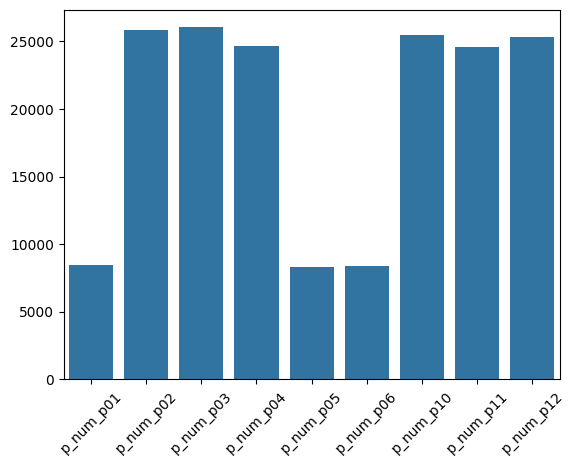

In [364]:
train_participants = ['p_num_p01','p_num_p02','p_num_p03','p_num_p04','p_num_p05','p_num_p06','p_num_p10','p_num_p11','p_num_p12']
visual = train_df[train_participants]
np_visual = visual.sum().to_numpy()
sns.barplot(x = train_participants, y = np_visual[0])
plt.xticks(rotation=45)

Interesting that there is less data for p01, p05, p06, maybe leave one out in training to test unseen performance? cv leaving a participant cv? leaving two out, stratified sample out, sample out, then ensamble them all either weighted avg, nn, or other

# First Basic Attempt
Lets train the model purely based on the blood glucose time history to sort out some kinks when training

First lets select the bg, time and person columns, lets limit it to only particiant 1 also

In [452]:
import statistics

def pattern_finder(sample_df: pl.DataFrame):
    df = sample_df
    
    missing_mask = df.select([pl.col(col).is_null().alias(col) for col in df.columns]).to_numpy()
    
    gaps = []
    gap_size = 0

    for column in missing_mask[0]:
        if column == 0:
            gaps.append(gap_size)
            gap_size = 0
        if column == 1:
            gap_size += 1
            
    for column in missing_mask[1]:
        if column == 0:
            gaps.append(gap_size)
            gap_size = 0
        if column == 1:
            gap_size += 1
    mode = statistics.mode(gaps)
    gaps = [x for x in gaps if x!= mode]
    if len(gaps) == 0:
        next_mode = -1 # here to signify no other missing data
    else:
        next_mode = statistics.mode(gaps)
    return mode,next_mode


In [455]:
metrics = ['bg','insulin','carbs','hr','steps','cals']# removed activity as categorical,'activity']
patterns = []
for participant in train_participants:
    for metric in metrics:
        sample_columns = [f'{metric}-{t}' for t in float_time_range(5.55,0.00,-0.05)]
        sample_columns = [f'{participant}','time'] + sample_columns + ['bg+1:00']
        sample_df = train_df[sample_columns].filter(pl.col(f'{participant}') == 1)
        pattern = pattern_finder(sample_df)
        patterns.append({'participant': participant, 'metric': metric, 'pattern': pattern})

patterns_df = pl.DataFrame(patterns)
patterns_df.filter(
    pl.col('pattern').list[0] > 0
)

participant,metric,pattern
str,str,list[i64]
"""p_num_p01""","""bg""","[2, 0]"
"""p_num_p05""","""bg""","[2, 0]"


From this pattern analysis we can see two clear groups with different recording frequencies for the blood glucose readings only, heavily hinting at different ontinuous glucose monitor devices. It is likely that the test set has a new monitor as the study is to generalise but this could be a potential feature.

Every 5 mins:
 - Participant 2
 - Participant 3
 - Participant 4
 - Participant 10
 - Participant 11
 - Participant 12

Every 15 Mins:
 - Participant 1
 - Participant 5 (with missing recordings at the start)
 - Participant 6 (with missing recordings at the start)


In [456]:
missed_readings_df = patterns_df.filter(
    pl.col('pattern').list[0] == 0,
    pl.col('pattern').list[1] > 0
).sort(pl.col('pattern').list[-1])
missed_readings_df


participant,metric,pattern
str,str,list[i64]
"""p_num_p06""","""bg""","[0, 2]"
"""p_num_p12""","""bg""","[0, 70]"
"""p_num_p01""","""carbs""","[0, 72]"
"""p_num_p01""","""hr""","[0, 72]"
"""p_num_p01""","""steps""","[0, 72]"
…,…,…
"""p_num_p11""","""steps""","[0, 72]"
"""p_num_p11""","""cals""","[0, 72]"
"""p_num_p12""","""carbs""","[0, 72]"


We can also see a large trend where most of the tests have a 6 hour gap semi regularly, with almost all having this same gap, Im assuming this is for charging the device overnight currently.

Lets have a quick look at the test set now and see what intervals we have

In [461]:
metrics = ['bg','insulin','carbs','hr','steps','cals']# removed activity as categorical,'activity']
patterns = []
test_participants = ['p_num_p01','p_num_p02','p_num_p04','p_num_p05','p_num_p06','p_num_p10','p_num_p11','p_num_p12','p_num_p15','p_num_p16','p_num_p18','p_num_p19','p_num_p21','p_num_p22','p_num_p24']
for participant in test_participants:
    for metric in metrics:
        sample_columns = [f'{metric}-{t}' for t in float_time_range(5.55,0.00,-0.05)]
        sample_columns = [f'{participant}','time'] + sample_columns
        sample_df = test_df[sample_columns].filter(pl.col(f'{participant}') == 1)
        pattern = pattern_finder(sample_df)
        patterns.append({'participant': participant, 'metric': metric, 'pattern': pattern})

test_patterns_df = pl.DataFrame(patterns)
test_patterns_df.filter(
    pl.col('pattern').list[0] > 0
)

participant,metric,pattern
str,str,list[i64]
"""p_num_p01""","""bg""","[2, 0]"
"""p_num_p05""","""bg""","[2, 0]"
"""p_num_p06""","""bg""","[2, 0]"
"""p_num_p18""","""steps""","[2, 0]"
"""p_num_p18""","""cals""","[1, 0]"
"""p_num_p19""","""steps""","[1, 2]"
"""p_num_p19""","""cals""","[1, 0]"


Now there are some columns that are categorical that need to be sorted out, lets fix the time column

I want to convert it to seconds, then normalise it

In [ ]:
def time_to_seconds(df, column = 'time'):
    
    return df.with_columns(
        (
            pl.col(column)
            .cast(pl.String)
            .str.split(':')
            .list.get(0).cast(pl.Int64).mul(3600) +  # hours to seconds
            pl.col(column)
            .cast(pl.String)
            .str.split(':')
            .list.get(1).cast(pl.Int64).mul(60) +  # minutes to seconds
            pl.col(column)
            .cast(pl.String)
            .str.split(':')
            .list.get(2).cast(pl.Int64)  # seconds
        ).alias(f'{column}_in_seconds')
    )
def normalise_time(df, column='time'):
    seconds_in_day = 24 * 60 * 60
    df = time_to_seconds(df, column)
    return df.with_columns(
        (pl.col(f'{column}_in_seconds') / seconds_in_day).alias('normalised_time')
    ).drop([column, f'{column}_in_seconds'])
    
    
    
sample_df = normalise_time(sample_df)
sample_df['normalised_time']

In [ ]:
sample_tensor = sample_df.to_torch()